In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.TopoExplanation import *
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')

## Import Diabetes dataset

In [3]:
df = pd.read_csv("../dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [4]:
X = df.drop(columns=["diabetes"]).to_numpy()
y_label = df["diabetes"].to_numpy()

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Train a Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y_label)
preds = model.predict_proba(X)[:, 0]  # just class 0 (binary classificaiton)

## Repeat perturbation based SHAP explanations with multiple trials

In [8]:
import shap
import shap
from tqdm import tqdm
shap_exps = []
for i in range(1,6):
    exps = []
    for j in range(5):
        explainer = shap.KernelExplainer(model=model.predict_proba,data=shap.kmeans(X,3))
        shap_values = explainer.shap_values(X,nsamples=i*100)
        exps.append(shap_values[0])
    shap_exps.append(exps)

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

## Parameter Tuning for Mapper

### Step 1: Compute the Mapper outputs for different resolutions and gains

In [9]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
all_bootstrap_dist = []
function = preds.reshape(-1,1)
for exps in tqdm(shap_exps):
    for exp in exps:
        bootstrap_dist = []
        for r in reversed(resolutions):
            b = []
            for g in gains:
                params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
                  "resolutions": np.array([r]), "gains": np.array([g]), "inp": "point cloud", 
                  "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=.2)}
                b.append(bootstrap_mapper(exp,params))
            bootstrap_dist.append(b) 
        all_bootstrap_dist.append(bootstrap_dist)

100%|██████████| 5/5 [21:01<00:00, 252.22s/it]


### Step 2: Visualize the 95% CI bootstrap distances and identify the minima
#### Note: Red rectangles are the parameter combination that we choose in the paper. This can be changed when the output from LIME is different.

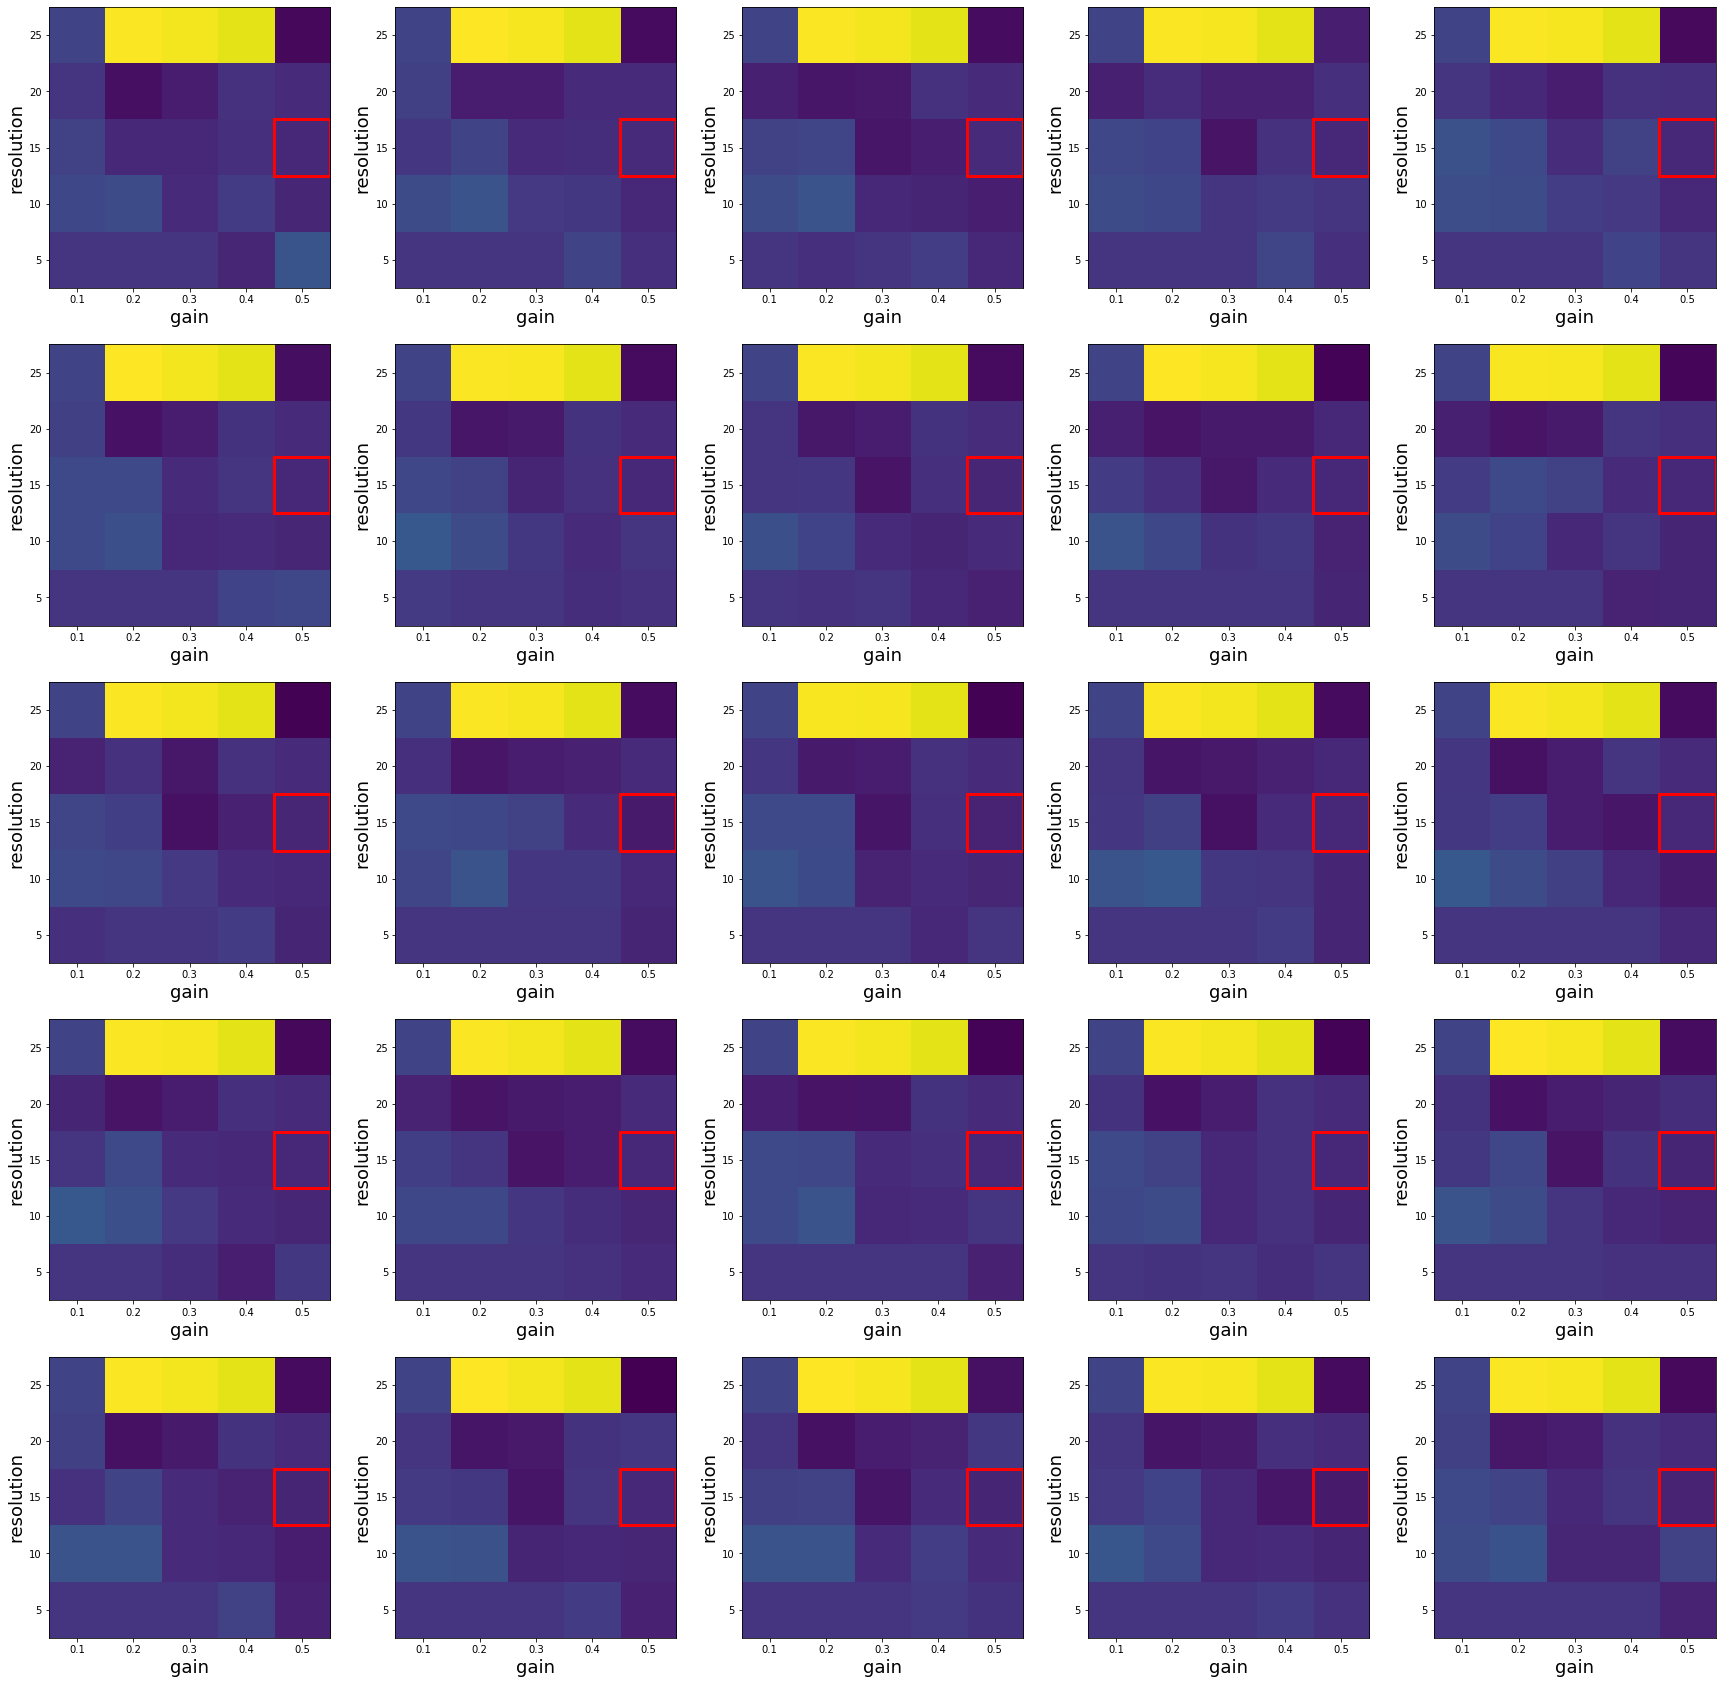

In [10]:
axes = plt.subplots(5, 5, figsize=(30,30))[1].reshape(-1)
vmin = np.min(all_bootstrap_dist)
vmax = np.max(all_bootstrap_dist)
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for b,ax in zip(all_bootstrap_dist,axes):
    ax.imshow(b,vmin=vmin,vmax=vmax)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(gains)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(resolutions)
    ax.set_ylim(-.5,4.5)
    ax.set_xlabel('gain', fontsize=18)
    ax.set_ylabel('resolution', fontsize=18)
    highlight_cell(4,2, ax=ax,color="red", linewidth=3)

Text(0.5, 1.0, '95% CI of bottleneck distances')

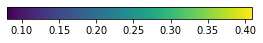

In [11]:
# axis of the colormap
a = np.array([[vmin,vmax]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal')
plt.title('95% CI of bottleneck distances')

In [45]:
resolution = 15
gain = 0.5
all_mappers = []
function = preds.reshape(-1,1)
params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
          "resolutions": np.array([resolution]), "gains": np.array([gain]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=.2)}
for exps in shap_exps:
    mappers = []
    for exp in exps:
        M = MapperComplex(**params).fit(exp)
        mappers.append(M)
    all_mappers.append(mappers)


## Visualizing the topological graphs

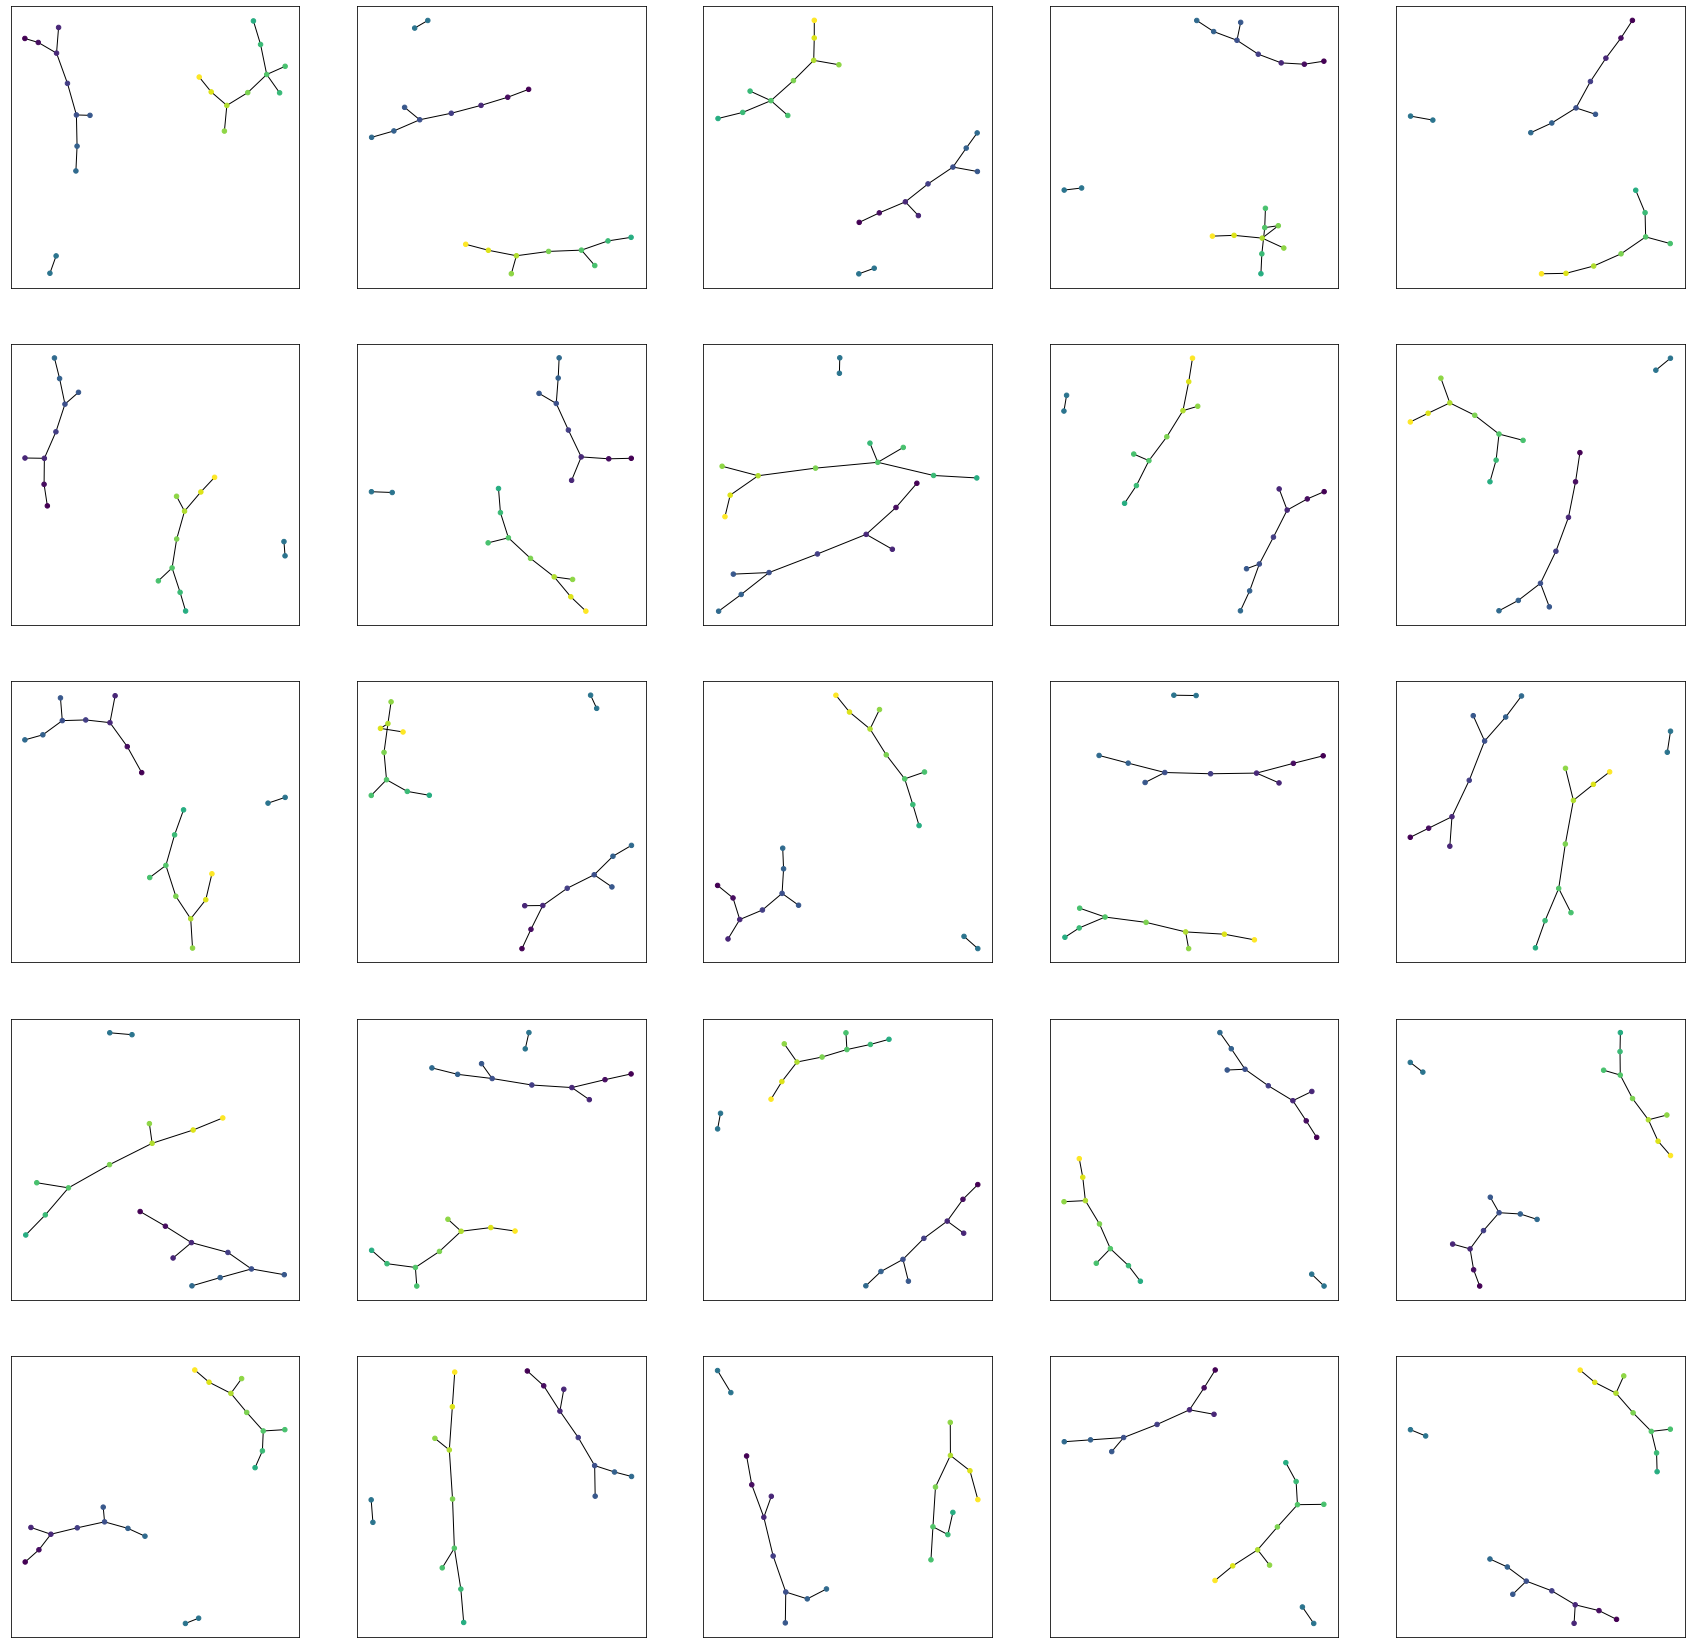

In [46]:
axes = plt.subplots(5, 5, figsize=(30,30))[1].reshape(-1)
all_mappers_flatten = []
vals = []
for ms in all_mappers:
    for m in ms:
        all_mappers_flatten.append(m)
for (M, ax) in zip(all_mappers_flatten, axes):
    G = mapper2networkx(M)
    nx.draw(G, pos=nx.spring_layout(G), 
            node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()], ax=ax,node_size=20)
    vals += [M.node_info_[node]["colors"][0] for node in G.nodes()]
    ax.axis('on')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()

Text(0.5, 1.0, 'Prediction Probability')

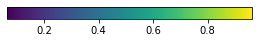

In [49]:
# axis of the colormap
a = np.array([[np.min(vals),np.max(vals)]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a)
plt.gca().set_visible(False)
plt.colorbar(orientation='horizontal')
plt.title('Prediction Probability')

In [50]:
all_dists = []
#calculate stability as the sum of pairwise distances for the graphs in different trials
stab = []
for i in range(5):
    dist = np.zeros((5,5))
    for j in range(5):
        for k in range(j,5):
            dist[j,k] = bottleneck_distance(all_mappers[i][j],all_mappers[i][k])
            dist[k,j] = dist[j,k]
    all_dists.append(dist)
    stab.append(np.sum(dist))

## Compute the pairwise distances among the topological graphs with multiple trials on different SHAP parameters.

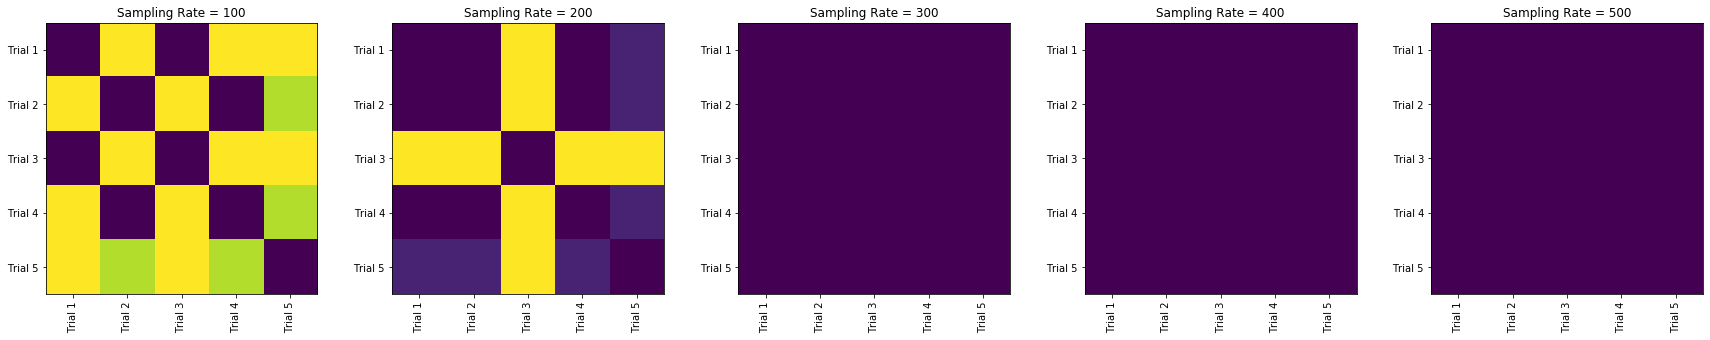

In [72]:
names = ['Trial {}'.format(i) for i in range(1,6)]
axes = plt.subplots(1, 5, figsize=(30,5))[1].reshape(-1)
i = 1
for d,ax in zip(all_dists,axes):
    ax.imshow(d,vmin=0,vmax=np.max(all_dists))
    ax.set_xticklabels(['']+names,rotation=90)
    ax.set_yticklabels(['']+names)
    ax.set_ylim(4.5,-.5)
    ax.set_title('Sampling Rate = {}'.format(i*100))
    i+=1
plt.show()

Text(0.5, 1.0, 'Bottleneck Distances')

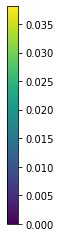

In [104]:
a = np.array([[0,np.max(all_dists)]])
plt.figure()
img = plt.imshow(a)
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(img)
plt.title('Bottleneck Distances')

## Plotting the row wise sum of pairwise distance matrices to reveal the stability

Text(0.5, 0, 'size of sampling in Shap')

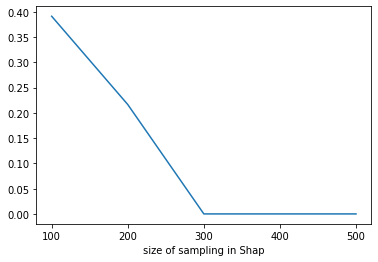

In [51]:
# plt.plot([np.sum(d,axis=0) for d in all_dists])
plt.plot(stab)
plt.xticks(np.arange(len(all_mappers)),[100,200,300,400,500,600])
plt.xlabel('size of sampling in Shap')